# Disjunctive Inequalities: big-Ms vs Convex-Hull Method

Consider the family of disjoint polytopes (i.e., bounded polyhedra)
\begin{align}
\mathcal P_i &:= \{ x \mid A_i x \leq b_i\} \quad i=1, \dots,n.
\end{align}

In this demo we use the Polyhedron class to analyze two standard ways to recast the disjunctive inequality
\begin{align}
x \in \bigcup_{i=1}^n \mathcal P_i
\end{align}
in the form of mixed-integer linear inequalities, namely: the big-M and the convex-hull method.

## Demo

In [1]:
# notebook settings
%load_ext autoreload
%autoreload 2

# external imports
import numpy as np
import matplotlib.pyplot as plt

# internal imports
from pympc.geometry.polyhedron import Polyhedron
from pympc.optimization.programs import linear_program

### Construction of the disjoint polytopes

In [2]:
# parameters
nx = 2
nA = 10
nP = 3
r = 5.

# collection of polytopes
P = []
for i in range(nP):
    A = np.random.randn(nA, nx)
    offset = np.random.rand(nx, 1)*r - np.ones((nx, 1))*r/2.
    b = np.random.rand(nA, 1) + A.dot(offset)
    P.append(Polyhedron(A, b))

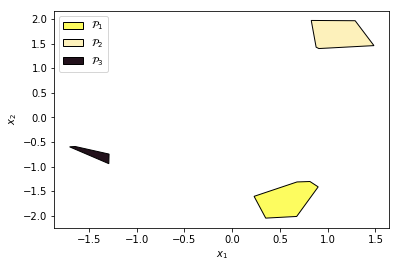

In [3]:
# function that loops over the polytopes and plot them
def plot_polytopes(P):
    for i, Pi in enumerate(P):
        Pi.plot(label=r'$\mathcal{P}_'+str(i+1)+'$', facecolor=np.random.rand(3))
        plt.legend()
plot_polytopes(P)

### Big-M reformulation
The big-M reformulation consists in the the following
\begin{align}
A_i x &\leq b_i + M_i (1 - \delta_i), \quad i=1, \ldots, n \\
\sum_{i=1}^n \delta_i &= 1,
\end{align}
where $M_i \geq 0$ are constant "big-enough" vectors and $\delta_i \in \{ 0, 1 \}$.
It is immediate to verify that
\begin{align}
\delta_i = 1 \Rightarrow x \in \mathcal P_i.
\end{align}

The smallest is the values of the big-Ms the more efficient the optimization will be.
Hence we use linear programming to fine the tighest possible big-Ms:
\begin{align}
M_i &:= \max_{j \in \{1, \ldots, s\}}
\left(
\max_{x \in \mathcal P_j} A_i x - b_i
\right)
, \quad
i \in \{1, \ldots, s\}, \\
\end{align}
where the maximization of a vector-valued function is meant elemntwise.

In [4]:
# solve a linear program for all ij to get the big-Ms
def get_big_m(P):
    M = []
    for i, Pi in enumerate(P):
        Mi = []
        for k in range(Pi.A.shape[0]):
            Mik = - np.inf
            for j, Pj in enumerate(P):
                f = - Pi.A[k:k+1,:].T
                sol = linear_program(f, Pj.A, Pj.b)
                Mijk = - sol['min'] - Pi.b[k,0]
                Mik = max(Mik, Mijk)
            Mi.append(Mik)
        M.append(np.array(Mi).reshape(Pi.A.shape[0],1))
    return M

In [5]:
def get_relaxation(P, M):
    nP = len(P)
    nx = P[0].A.shape[1]
    A_relaxed = np.zeros((0, nx+nP))
    b_relaxed = np.zeros((0, 1))
    P_relaxed = Polyhedron(A_relaxed, b_relaxed)
    for i, Pi in enumerate(P):
        nAi = Pi.A.shape[0]
        Ai_relaxed = np.hstack((
            Pi.A,
            np.zeros((nAi, i)),
            M[i],
            np.zeros((nAi, nP-i-1))
        ))
        bi_relaxed = Pi.b + M[i]
        Pi_relaxed = Polyhedron(Ai_relaxed, bi_relaxed)
        Pi_relaxed.add_lower_bound(np.zeros((nP, 1)), range(nx,nx+nP))
        Pi_relaxed.add_inequality(
            np.hstack((np.zeros((1, nx)), np.ones((1, nP)))),
            np.ones((1,1))
        )
        Pi_relaxed.add_inequality(
            np.hstack((np.zeros((1, nx)), -np.ones((1, nP)))),
            -np.ones((1,1))
        )
        P_relaxed.add_inequality(Pi_relaxed.A, Pi_relaxed.b)
    return P_relaxed

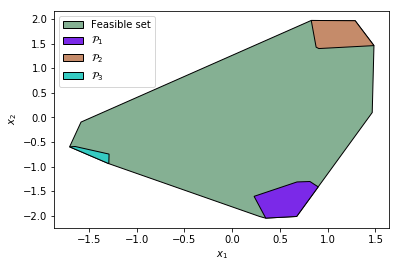

In [6]:
# plot relaxation
M = get_big_m(P)
P_relaxed = get_relaxation(P, M)
feasible_set = P_relaxed.project_to([0,1])
feasible_set.plot(
        label=r'Feasible set',
        facecolor=np.random.rand(3)
)
plot_polytopes(P)

As it can be seen choosing the best possible big-Ms makes the relaxation a rather good approximation of the convex hull of the collection of polytopes. Nonetheless, there are cases in which the result is very good and there are others in which the result is very poor...

### Convex-hull method

The convex-hull reformulation, on the other hand, consists in
\begin{align}
A_i x_i &\leq b_i \delta_i, \quad i=1, \ldots, n \\
\sum_{i=1}^n x_i &= x, \\
\sum_{i=1}^n \delta_i &= 1,
\end{align}
where $x_i$ are auxiliary variables and $\delta_i \in \{ 0, 1 \}$.

If $\delta_i = 1$, we have that $\delta_j = 0$, $\forall j \neq i$.
Being all the polytopes bounded, we then have
\begin{align}
A_j x_j = 0
\Rightarrow
x_j = 0
\Rightarrow
x = x_i
\Rightarrow
A_i x &\leq b_i
\end{align}
as desired.

The convex-hull method derives his name from the fact that, after relaxing the binaries $\delta_i$ to assume values in the interval $[0,1]$, the set of $x$ "shadowed" by the above set is exactly $\text{conv} (\bigcup_{i=1}^n \mathcal P_i)$.
In fact, it is sufficient to consider $p_i := x_i/\delta_i$ to see that any $x$ verifying the above set of equations must lie in $\text{conv} (\{ p_i \}_{i=1}^n)$ for $p_i \in \mathcal P_i$.

In our specific case we can simply consider
\begin{align}
A_1 x_1 &\leq b_1 (1 - \delta), \\
A_2 (x - x_1) &\leq b_2 \delta,
\end{align}
with $\delta \in \{ 0, 1 \}$.

In [9]:
# polytope n.1
A1_relaxed = np.hstack((np.zeros((A1.shape[0], A1.shape[1])), A1, b1))
P1_relaxed = Polyhedron(A1_relaxed, b1)
P1_relaxed.add_bounds(0., 1., [4])

# polytope n.2
A2_relaxed = np.hstack((A2, -A2, -b2))
b2_relaxed = np.zeros(b2.shape)
P2_relaxed = Polyhedron(A2_relaxed, b2_relaxed)
P2_relaxed.add_bounds(0., 1., [4])

# constraint and feasible set
cs = P1_relaxed.intersection(P2_relaxed)
fs = cs.project_to([0,1])

# plot relaxation
fs.plot(label=r'Relaxation feasible set', facecolor='b')
P1.plot(label=r'$\mathcal{P}_1$', facecolor='r')
P2.plot(label=r'$\mathcal{P}_2$', facecolor='g')
plt.legend()
plt.show()

NameError: name 'A1' is not defined

### Final comments

The first thing to notice is that the convex-hull method does not require any "big-enough" constant, whose choice in some cases might result rather arbitrary...

Secondly, the relaxation performed by the convex-hull method is much tighter than the one of the big-M method (actually it is the tightest by definition!). This is very useful in branch-and-bound algorithms since it increases the values of the lower bounds deriving from the problem relaxations, making the convergence of the search much faster.

However, it is worth to notice that, the big-M method does not introduce auxiliary variables, hence it results in relaxations with less optimization variables.